In [ ]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import root_mean_squared_error, r2_score

Loading and preprocessing Data

In [ ]:
csv1 = pd.read_csv("1mayo - agosto 2021.csv",quoting=csv.QUOTE_NONE)
csv2 = pd.read_csv("2agosto -dic 2021.csv",quoting=csv.QUOTE_NONE)

train = csv1.copy()
test = csv2.copy()

In [ ]:
def data_preprocessing(df):

    df.columns = df.columns.str.replace('"','')
    df.replace({r'"': ''}, regex=True, inplace=True)

    df = df.drop(['MAC','fecha_servidor'],axis=1)
    
    df['fecha_esp32'] = pd.to_datetime(df['fecha_esp32'], format='%Y-%m-%d %H:%M:%S')
    df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]]=df[["voltaje","corriente","potencia","frecuencia","energia","fp","ESP32_temp","WORKSTATION_CPU",
        "WORKSTATION_CPU_POWER","WORKSTATION_CPU_TEMP","WORKSTATION_GPU","WORKSTATION_GPU_POWER","WORKSTATION_GPU_TEMP",
        "WORKSTATION_RAM","WORKSTATION_RAM_POWER"]].astype(float)
    df['weekday']=df['weekday'].astype(int)
    
    
    return df

train = data_preprocessing(train)
test = data_preprocessing(test)

Split the dataframe into sleeping part and working part

In [ ]:
sleeping_df_train = train[train['WORKSTATION_CPU_POWER'] == 0]
working_df_train = train[train['WORKSTATION_CPU_POWER'] != 0]
sleeping_df_test = test[test['WORKSTATION_CPU_POWER'] == 0]
working_df_test = test[test['WORKSTATION_CPU_POWER'] != 0]

working_df_train.head()

,weekday,fecha_esp32,voltaje,corriente,potencia,frecuencia,energia,fp,ESP32_temp,WORKSTATION_CPU,WORKSTATION_CPU_POWER,WORKSTATION_CPU_TEMP,WORKSTATION_GPU,WORKSTATION_GPU_POWER,WORKSTATION_GPU_TEMP,WORKSTATION_RAM,WORKSTATION_RAM_POWER
4145154,4,2021-06-10 02:13:04,119.9,1.14,125.1,59.9,81.89,0.92,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145155,4,2021-06-10 02:13:05,120.0,1.04,113.3,59.9,81.89,0.91,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145156,4,2021-06-10 02:13:06,119.9,1.17,128.4,60.0,81.89,0.92,33.89,11.28,36.71,33.0,1.0,35.0,15.00,32.29,6.97
4145157,4,2021-06-10 02:13:07,119.9,1.17,128.4,60.0,81.89,0.92,33.89,13.67,36.36,36.0,2.0,35.0,14.51,32.45,10.16
4145158,4,2021-06-10 02:13:08,120.0,1.08,117.9,60.0,81.89,0.91,33.89,13.67,36.36,36.0,2.0,35.0,14.51,32.45,10.16


Feature engineering

In [ ]:
def feature_engineering(df):
    
    df['Total_Workstation_Power'] = df['WORKSTATION_CPU_POWER'] + df['WORKSTATION_GPU_POWER'] + df['WORKSTATION_RAM_POWER']
    df['PUE'] = df['potencia'] / df['Total_Workstation_Power']

    df['Temp_Gradient'] = df['WORKSTATION_CPU_POWER']-df['ESP32_temp']
    df['Temp_load'] = df['WORKSTATION_CPU']*df['WORKSTATION_CPU_POWER']

    return df

working_df_train = feature_engineering(working_df_train)
working_df_test = feature_engineering(working_df_test)

working_df_train.head()

C:\Users\virvi\AppData\Local\Temp\ipykernel_18820\2128035859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total_Workstation_Power'] = df['WORKSTATION_CPU_POWER'] + df['WORKSTATION_GPU_POWER'] + df['WORKSTATION_RAM_POWER']
C:\Users\virvi\AppData\Local\Temp\ipykernel_18820\2128035859.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUE'] = df['potencia'] / df['Total_Workstation_Power']
C:\Users\virvi\AppData\Local\Temp\ipykernel_18820\2128035859.py:7: SettingWithCopyWarning: 
A value is tryi

,weekday,fecha_esp32,voltaje,corriente,potencia,frecuencia,energia,fp,ESP32_temp,WORKSTATION_CPU,...,WORKSTATION_CPU_TEMP,WORKSTATION_GPU,WORKSTATION_GPU_POWER,WORKSTATION_GPU_TEMP,WORKSTATION_RAM,WORKSTATION_RAM_POWER,Total_Workstation_Power,PUE,Temp_Gradient,Temp_load
4145154,4,2021-06-10 02:13:04,119.9,1.14,125.1,59.9,81.89,0.92,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.589985,2.82,414.0888
4145155,4,2021-06-10 02:13:05,120.0,1.04,113.3,59.9,81.89,0.91,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.440010,2.82,414.0888
4145156,4,2021-06-10 02:13:06,119.9,1.17,128.4,60.0,81.89,0.92,33.89,11.28,...,33.0,1.0,35.0,15.00,32.29,6.97,78.68,1.631927,2.82,414.0888
4145157,4,2021-06-10 02:13:07,119.9,1.17,128.4,60.0,81.89,0.92,33.89,13.67,...,36.0,2.0,35.0,14.51,32.45,10.16,81.52,1.575074,2.47,497.0412
4145158,4,2021-06-10 02:13:08,120.0,1.08,117.9,60.0,81.89,0.91,33.89,13.67,...,36.0,2.0,35.0,14.51,32.45,10.16,81.52,1.446271,2.47,497.0412


Choose the specific features for training

In [ ]:
y = working_df_train['PUE']
X = working_df_train.drop(['PUE','fecha_esp32','potencia','energia','Total_Workstation_Power','WORKSTATION_CPU_POWER','WORKSTATION_GPU_POWER','WORKSTATION_RAM_POWER'], axis=1)
y_test = working_df_test['PUE']
X_test = working_df_test.drop(['PUE','fecha_esp32','potencia','energia','Total_Workstation_Power','WORKSTATION_CPU_POWER','WORKSTATION_GPU_POWER','WORKSTATION_RAM_POWER'], axis=1)

Set up model params

In [20]:
lr_params = {
    'fit_intercept': True,
    'positive': True,
    'copy_X': True
}

In [13]:
dt_params = {
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

In [54]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

Train models

In [ ]:
model_lr_1 = LinearRegression(**lr_params)
y_pred_lr_1 = model_lr_1.fit(X, y).predict(X_test)
model_dt_1 = DecisionTreeRegressor(**dt_params)
y_pred_dt_1 = model_dt_1.fit(X, y).predict(X_test)
model_rf_1 = RandomForestRegressor(**rf_params)
y_pred_rf_1 = model_rf_1.fit(X, y).predict(X_test)

Models' score

In [ ]:
rmse_lr_1 = root_mean_squared_error(y_test,y_pred_lr_1)
r2_lr_1 = r2_score(y_test,y_pred_lr_1)
rmse_dt_1 = root_mean_squared_error(y_test,y_pred_dt_1)
r2_dt_1 = r2_score(y_test,y_pred_dt_1)
rmse_rf_1 = root_mean_squared_error(y_test,y_pred_rf_1)
r2_rf_1 = r2_score(y_test,y_pred_rf_1)
print(f"Linear Regression - RMSE: {rmse_lr_1}, R2: {r2_lr_1}")
print(f"Decision Tree - RMSE: {rmse_dt_1}, R2: {r2_dt_1}")
print(f"Random Forest - RMSE: {rmse_rf_1}, R2: {r2_rf_1}")

Linear Regression - RMSE: 0.168438640412022, R2: -0.27077345752510973
Decision Tree - RMSE: 0.0709529625013783, R2: 0.774510799253256
Random Forest - RMSE: 0.07559463703123778, R2: 0.7440432112276467


Visualization

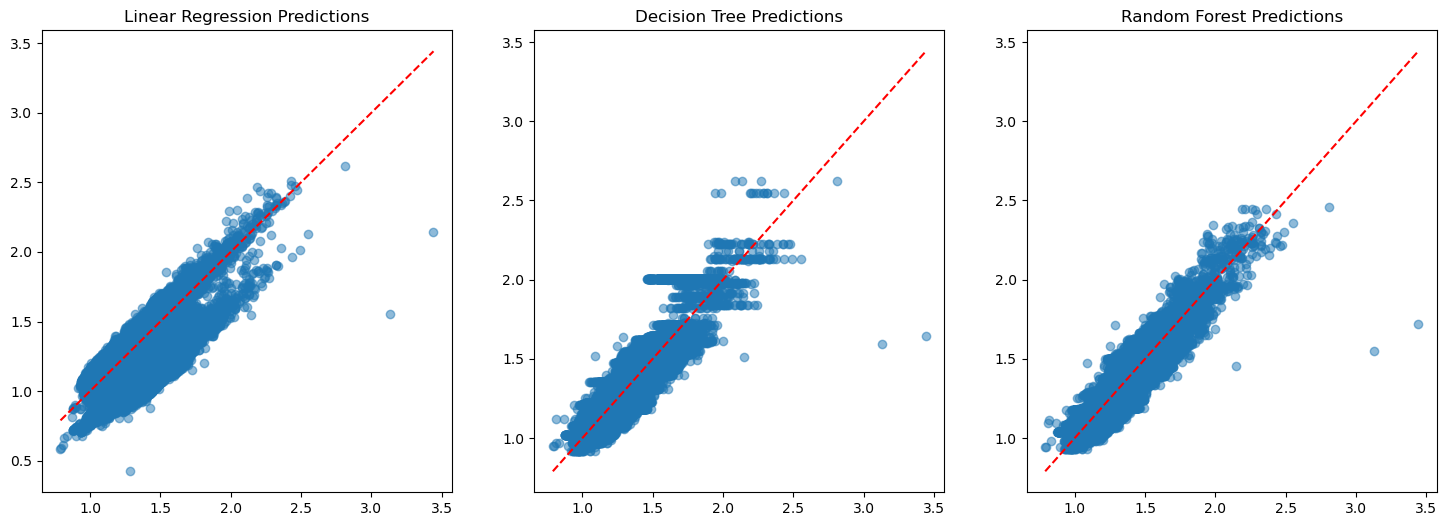

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.scatter(y_test, y_pred_lr_1, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title('Linear Regression Predictions')
ax2.scatter(y_test, y_pred_dt_1, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_title('Decision Tree Predictions')
ax3.scatter(y_test, y_pred_rf_1, alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax3.set_title('Random Forest Predictions')
plt.show()


Transform the features to improve models

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

Train again

In [ ]:
model_lr_2 = LinearRegression(**lr_params)
y_pred_lr_2 = model_lr_2.fit(X, y).predict(X_test)
model_dt_2 = DecisionTreeRegressor(**dt_params)
y_pred_dt_2 = model_dt_2.fit(X, y).predict(X_test)
model_rf_2 = RandomForestRegressor(**rf_params)
y_pred_rf_2 = model_rf_2.fit(X, y).predict(X_test)

In [ ]:
rmse_lr_2 = root_mean_squared_error(y_test,y_pred_lr_2)
r2_lr_2 = r2_score(y_test,y_pred_lr_2)
rmse_dt_2 = root_mean_squared_error(y_test,y_pred_dt_2)
r2_dt_2 = r2_score(y_test,y_pred_dt_2)
rmse_rf_2 = root_mean_squared_error(y_test,y_pred_rf_2)
r2_rf_2 = r2_score(y_test,y_pred_rf_2)
print(f"Linear Regression - RMSE: {rmse_lr_2}, R2: {r2_lr_2}")
print(f"Decision Tree - RMSE: {rmse_dt_2}, R2: {r2_dt_2}")
print(f"Random Forest - RMSE: {rmse_rf_2}, R2: {r2_rf_2}")

Linear Regression - RMSE: 0.18630583745645715, R2: -0.5546678088187749
Decision Tree - RMSE: 0.07000946649892767, R2: 0.7804678063815935
Random Forest - RMSE: 0.07514497441869944, R2: 0.7470791908453526


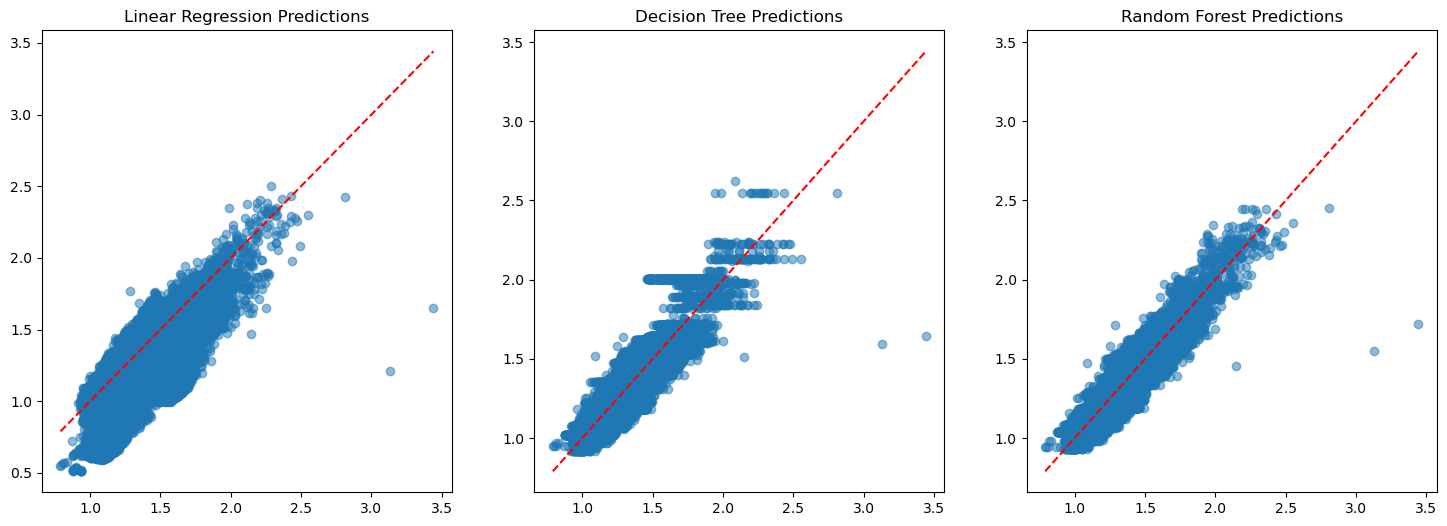

In [61]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.scatter(y_test, y_pred_lr_2, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title('Linear Regression Predictions')
ax2.scatter(y_test, y_pred_dt_2, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_title('Decision Tree Predictions')
ax3.scatter(y_test, y_pred_rf_2, alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax3.set_title('Random Forest Predictions')
plt.show()

Try boosting

Set up model params

In [27]:
GBDT_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42
}

In [28]:
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42
}

In [29]:
lgb_params = {
    'objective': 'regression',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'random_state': 42
}

Train models

In [34]:
model_GBDT_1 = GradientBoostingRegressor(**GBDT_params)
y_pred_GBDT_1 = model_GBDT_1.fit(X, y).predict(X_test)
model_xgb_1 = xgb.XGBRegressor(**xgb_params)
y_pred_xgb_1 = model_xgb_1.fit(X, y).predict(X_test)
model_lgb_1 = lgb.LGBMRegressor(**lgb_params)
y_pred_lgb_1 = model_lgb_1.fit(X, y).predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1315
[LightGBM] [Info] Number of data points in the train set: 560909, number of used features: 13
[LightGBM] [Info] Start training from score 1.159838


In [37]:
rmse_GBDT_1 = root_mean_squared_error(y_test,y_pred_GBDT_1)
r2_GBDT_1 = r2_score(y_test,y_pred_GBDT_1)
rmse_xgb_1 = root_mean_squared_error(y_test,y_pred_xgb_1)
r2_xgb_1 = r2_score(y_test,y_pred_xgb_1)
rmse_lgb_1 = root_mean_squared_error(y_test,y_pred_lgb_1)
r2_lgb_1 = r2_score(y_test,y_pred_lgb_1)
print(f"GradientBoost - RMSE: {rmse_GBDT_1}, R2: {r2_GBDT_1}")
print(f"XGBoost - RMSE: {rmse_xgb_1}, R2: {r2_xgb_1}")
print(f"LightGBM - RMSE: {rmse_lgb_1}, R2: {r2_lgb_1}")

GradientBoost - RMSE: 0.05541652835178631, R2: 0.8624491396138068
XGBoost - RMSE: 0.05698479215996702, R2: 0.8545537200361915
LightGBM - RMSE: 0.05122049808178237, R2: 0.8824906902116252


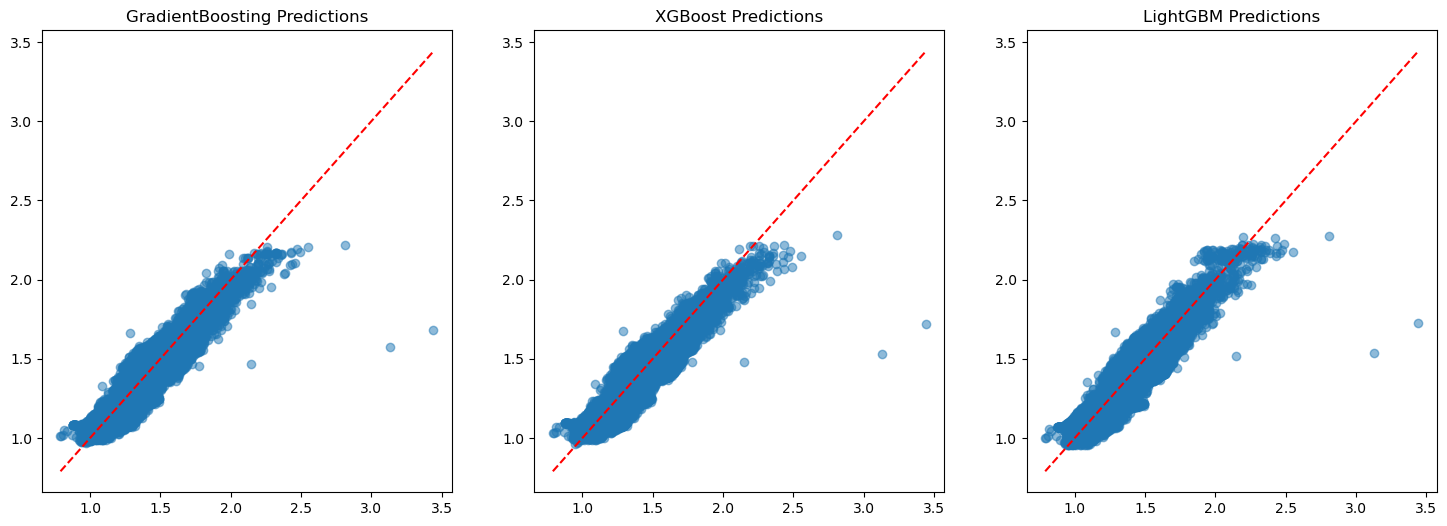

In [38]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))
ax1.scatter(y_test, y_pred_GBDT_1, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title('GradientBoosting Predictions')
ax2.scatter(y_test, y_pred_xgb_1, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_title('XGBoost Predictions')
ax3.scatter(y_test, y_pred_lgb_1, alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax3.set_title('LightGBM Predictions')
plt.show()

In [63]:
#Cross Validation
n_folds = 5
oof_predictions = np.zeros(len(X))
test_predictions = np.zeros(len(X_test))
models = []
    

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        

    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    models.append(model)
    
    val_pred = model.predict(X_val)
    oof_predictions[val_idx] = val_pred
        
    test_pred = model.predict(X_test)
    test_predictions += test_pred / n_folds
        
rmse_rf_cv = root_mean_squared_error(y_test,test_predictions)
r2_rf_cv = r2_score(y_test, test_predictions)
    

In [65]:
print(f"CrossValidation - RMSE: {rmse_rf_cv}, R2: {r2_rf_cv}")

CrossValidation - RMSE: 0.07481210128165022, R2: 0.7493149776684747


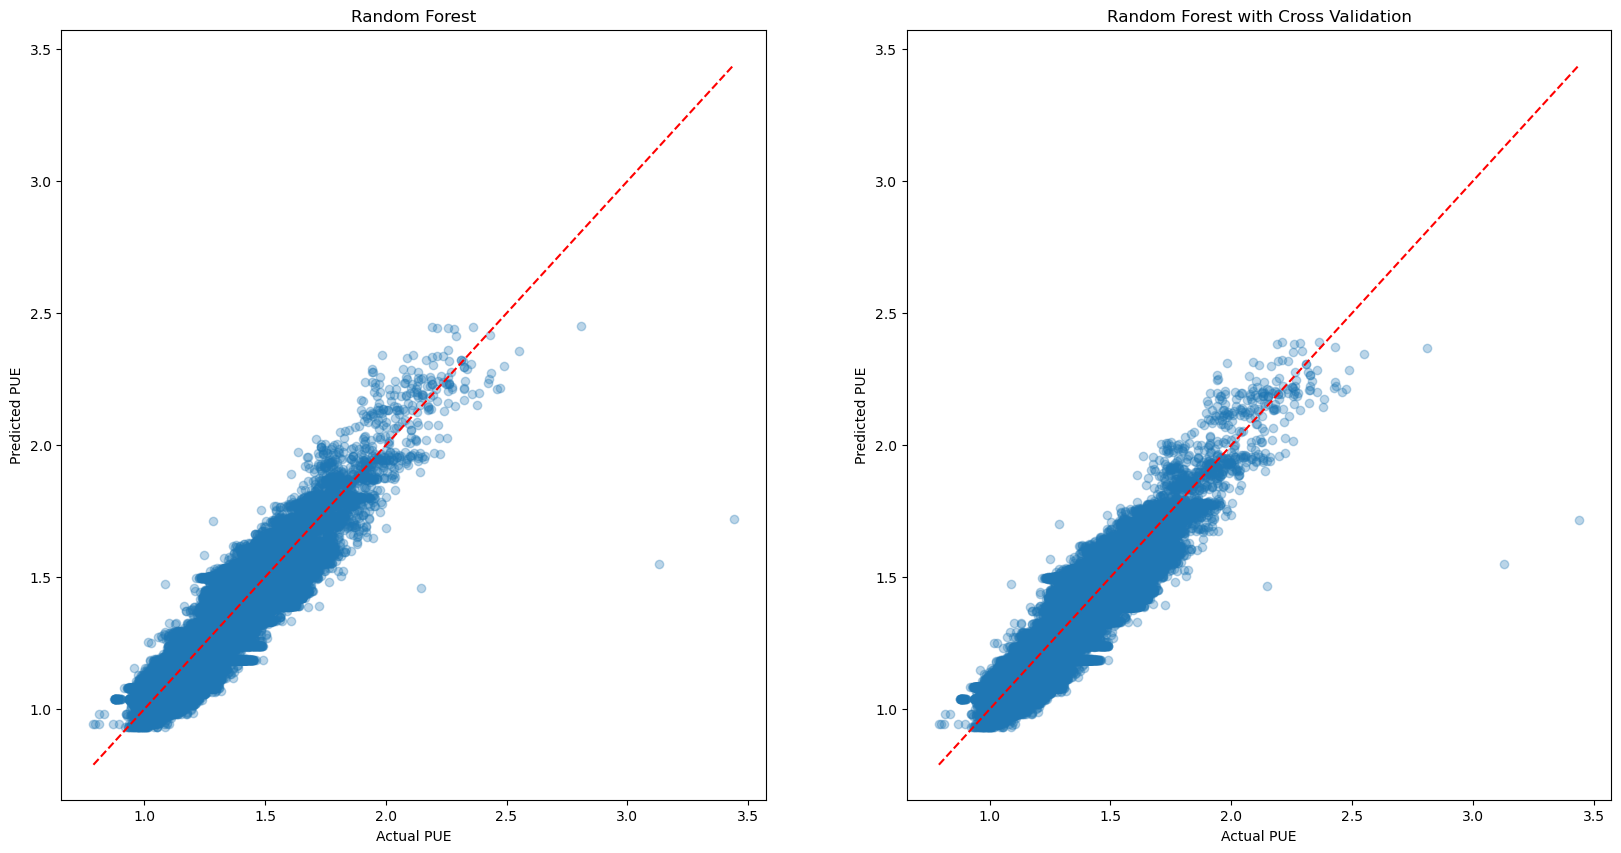

In [64]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.scatter(y_test, y_pred_rf_2, alpha=0.3)
ax1.set_xlabel('Actual PUE')
ax1.set_ylabel('Predicted PUE')
ax1.set_title('Random Forest')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.scatter(y_test, test_predictions, alpha=0.3)
ax2.set_xlabel('Actual PUE')
ax2.set_ylabel('Predicted PUE')
ax2.set_title('Random Forest with Cross Validation')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show() 